В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

####Imports

In [47]:
#Imports and format
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import operator


from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer




import statsmodels.api as sm
from patsy import dmatrices
from IPython.display import display




from google.colab import drive

pd.set_option('display.max.rows',130)
pd.set_option('display.max.columns',130)
pd.set_option('float_format', '{:.2f}'.format)


####Variables

In [63]:
path_to_data = '/content/drive/MyDrive/Python/ML/DATA/Kaggle/Bank/train.csv.zip'
path_to_data_4 = '/content/drive/MyDrive/Python/ML/DATA/regression_data.csv'
models_regulation = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]


####Functions

In [77]:
#Functions

def compute_auroc_and_build_roc(inputs, targets, model, name=''):
    # Predict probabilities
    model = model
    y_pred_proba = model.predict_proba(inputs)[:, 1]

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(targets, y_pred_proba)

      # Compute AUROC
    roc_auc = auc(fpr, tpr)
    print(f'AUROC for {name}: {roc_auc:.2f}')

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
    plt.legend(loc="lower right")
    plt.show()

# Helper function to predict, compute accuracy & plot confusion matrix
def predict_and_plot(inputs, targets, model, name=''):
    model=model
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    f1_score_ = f1_score(targets, preds)

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print(f"F1 score {name}: {f1_score_:.2f}%")

    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

def get_f1_score(inputs, targets, model, name=''):
    model = model
    preds = model.predict(inputs)

    f1_score_ = f1_score(targets, preds)
    print(f"F1 score {name}: {f1_score_:.2f}%") (name)
    return preds

def poly_reg (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, model):
    y_pred_train_poly = model.predict(train_inputs_4)
    y_pred_val_poly = model.predict(val_inputs_4)

    # Оцінка моделей
    rmse_poly_train = mean_squared_error(train_targets_4, y_pred_train_poly, squared=False)
    rmse_poly_val = mean_squared_error(val_targets_4, y_pred_val_poly, squared=False)

    print(f"Train RMSE for Polynomial Regression: {np.sqrt(rmse_poly_train):.3f}")
    print(f"Val RMSE for Polynomial Regression: {np.sqrt(rmse_poly_val):.3f}")

def evaluate_model(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    train_metrics = mean_squared_error(y_train, y_train_pred, squared=False).round(6)
    val_metrics = mean_squared_error(y_val, y_val_pred, squared=False).round(6)

    return dict(train=train_metrics, val=val_metrics)

def poly_f (train_inputs_4, val_inputs_4, deg =20):
    poly_features = PolynomialFeatures(degree = deg)
    X_train_poly = poly_features.fit_transform(train_inputs_4)
    X_val_poly = poly_features.transform(val_inputs_4)

    return poly_features, X_train_poly, X_val_poly


def regul_polyfeature (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, deg =20):
    poly_features, X_train_poly, X_val_poly = poly_f (train_inputs_4, val_inputs_4, deg = deg)

    import warnings

    warnings.filterwarnings("ignore")

    for mod in models_regulation:
        mod.fit(X_train_poly, train_targets_4)
        eval_results  = evaluate_model(mod, X_train_poly, train_targets_4, X_val_poly, val_targets_4)
        print(f'{str(mod)}: {eval_results}\n')


#1

####Data

#####1.1

In [5]:
#Read data
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df = pd.read_csv(path_to_data)
df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [7]:
input_cols = df[['id', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']]
target_col = df['Exited']

#####1.2

In [8]:
#Devide for datasets
train_inputs, val_inputs, train_targets, val_targets = train_test_split(input_cols, target_col, test_size=0.2, random_state=12, stratify=target_col)

#####1.3

In [9]:
asis_col = ['id']
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.difference(asis_col).tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

##Pipeline

#####1.4

In [10]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



#####1.5

In [11]:
# Create a pipeline that includes preprocessing and the model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


#####1.6

In [12]:
# Train the model
model_pipeline.fit(train_inputs, train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

#####1.7

Accuracy: 87.27%
F1 score Train: 0.63%


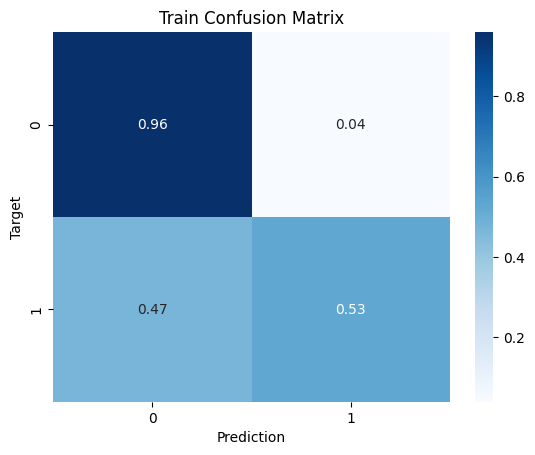

Accuracy: 87.57%
F1 score Validation: 0.65%


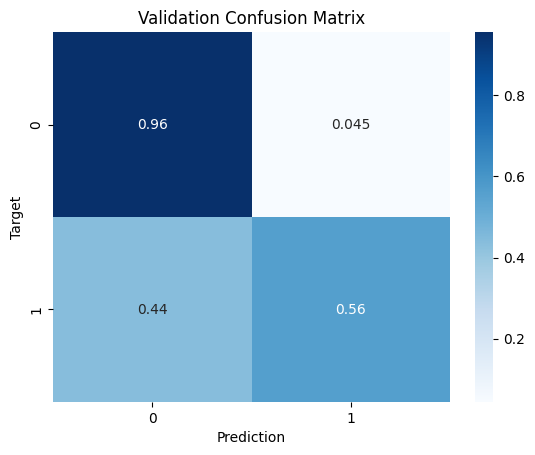

In [13]:
# Evaluate on validation and test set
train_preds = predict_and_plot(train_inputs, train_targets, model_pipeline, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, model_pipeline, 'Validation')

#####1.8

In [14]:
# Save the trained model
joblib.dump(model_pipeline, 'bank_pipeline.joblib')

['bank_pipeline.joblib']

In [15]:
# Load the trained model
model_pipeline_loaded = joblib.load('bank_pipeline.joblib')


#####перевірка збереженої моделі

In [16]:
# Робимо прогнози
y_pred =  model_pipeline_loaded.predict(train_inputs)

# Оцінюємо модель
accuracy = accuracy_score(train_targets, y_pred)
print(f'AUC: {accuracy:.2f}')



AUC: 0.87


#**2**

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

In [17]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer_2 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_2', PolynomialFeatures(2))
    ])

categorical_transformer_2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

# Combine transformers into a preprocessor
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_2, numeric_cols),
        ('cat', categorical_transformer_2, categorical_cols)
    ])


In [18]:
model_pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(solver='liblinear'))
])


In [19]:
model_pipeline_2.fit(train_inputs, train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_2',
                                                                   PolynomialFeatures())]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Accuracy: 89.08%
F1 score Train: 0.69%


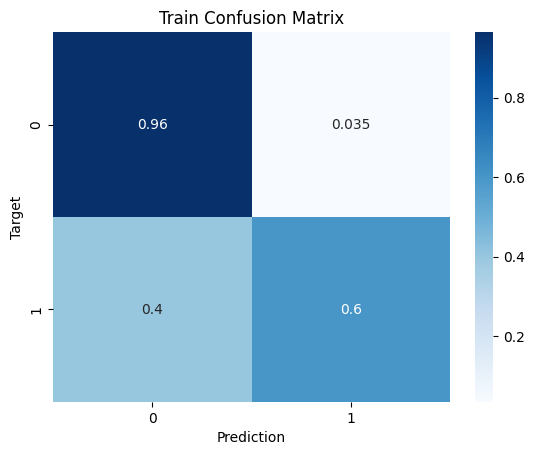

Accuracy: 89.23%
F1 score Validation: 0.70%


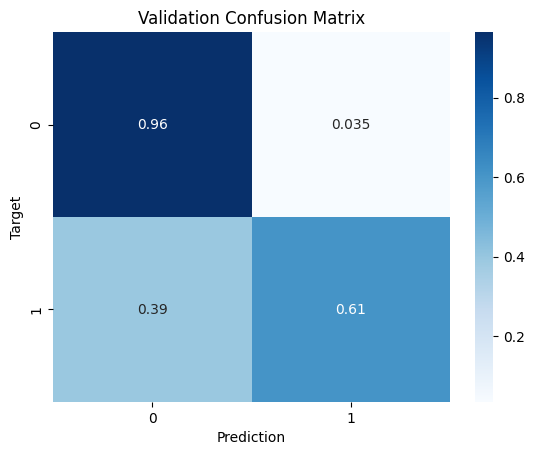

In [20]:
# Evaluate on validation and test set
train_preds = predict_and_plot(train_inputs, train_targets, model_pipeline_2, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, model_pipeline_2, 'Validation')

**Висновки:**
Модель з поліномінальними даними у другому ступені є більш точною аніж без поліномінальних ознак. Високий скор на тренувальних даних, а тому більшість, що відсутні ознаки недонавчання, а на валідаційному вище, аніж на тренувальному - тому модель не є перенавченою.

#3

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

In [21]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer_3 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_3', PolynomialFeatures(4))
    ])

categorical_transformer_3 = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ])

# Combine transformers into a preprocessor
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_3, numeric_cols),
        ('cat', categorical_transformer_3, categorical_cols)
    ])


In [22]:
model_pipeline_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', LogisticRegression(solver='liblinear'))
])


In [23]:
model_pipeline_3.fit(train_inputs, train_targets)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_3',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['Age', 'Balance',
                                                   'CreditScore',
                                                   'EstimatedSalary',
                                                   'HasCrCard',
                                                   'IsActiveMember',
                                                   'NumOfProducts', 'Tenure']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

Accuracy: 90.11%
F1 score Train: 0.73%


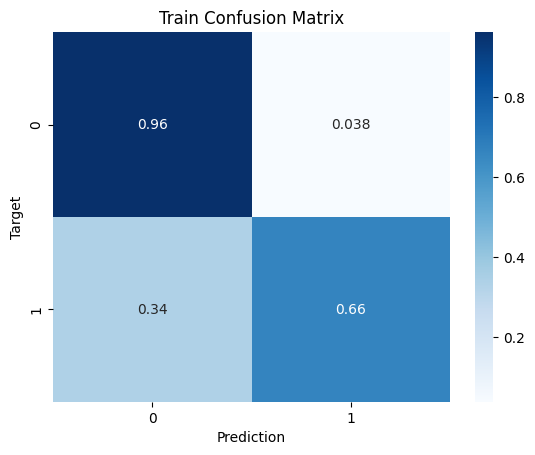

Accuracy: 90.13%
F1 score Validation: 0.73%


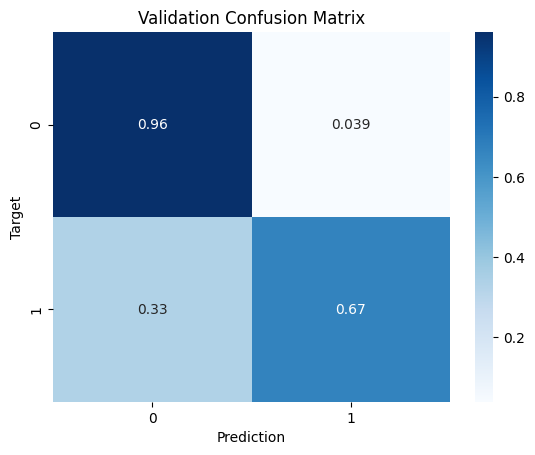

In [24]:
# Evaluate on validation and test set
train_preds = predict_and_plot(train_inputs, train_targets, model_pipeline_3, 'Train')
val_preds = predict_and_plot(val_inputs, val_targets, model_pipeline_3, 'Validation')

**Висновки:**
Модель з поліномінальними даними у четвертому ступені є більш точною ознаками другог ступеню. Високий скор на тренувальних даних, а тому більшість, що відсутні ознаки недонавчання, а на валідаційному вище, аніж на тренувальному - тому модель не є перенавченою.

#4

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [25]:
df_4 = pd.read_csv(path_to_data_4)
df_4.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'target'],
      dtype='object')

In [26]:
input_cols_4 = df_4 [['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']]
target_col_4 = df_4['target']

In [27]:
#Devide for datasets
train_inputs_4, val_inputs_4, train_targets_4, val_targets_4 = train_test_split(input_cols_4, target_col_4, test_size=0.2, random_state=12)

In [28]:
numeric_cols_4 = train_inputs_4.select_dtypes(include=np.number).columns.tolist()

In [29]:
# Create preprocessing pipelines for both numeric and categorical data
numeric_transformer_4 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly_4', PolynomialFeatures(5))
    ])
# Combine transformers into a preprocessor
preprocessor_4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_4, numeric_cols_4),
    ])


In [30]:
model_pipeline_4 = Pipeline(steps=[
    ('preprocessor', preprocessor_4),
    ('classifier', LinearRegression())
])

In [31]:
model_pipeline_4.fit(train_inputs_4, train_targets_4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly_4',
                                                                   PolynomialFeatures(degree=5))]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('classifier', LinearRegression())])

In [32]:
poly_reg (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, model_pipeline_4)

Train RMSE for Polynomial Regression: 0.000
Val RMSE for Polynomial Regression: 4.661


In [44]:
np.std(df_4.target)


45.2900512848008

**Висновки:**
Дана модель має ознаки перенавченості, бо на тренувальних взагалі відсутні помилки, а на валідаційному наборі вже зявляються помилки, але не перевищують стандарне відхилення.

#5

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лог регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

##degree = 20

In [78]:
regul_polyfeature (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, deg =20)

LinearRegression(): {'train': 5.3e-05, 'val': 4465490465.142694}

Ridge(): {'train': 23.516342, 'val': 308236624.808938}

Lasso(): {'train': 2.282417, 'val': 1136.284663}

ElasticNet(): {'train': 10.273032, 'val': 67821.661287}

ElasticNet(alpha=0.5): {'train': 7.954609, 'val': 45666.901995}



##degree = 5

In [79]:
regul_polyfeature (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, deg = 5)

LinearRegression(): {'train': 0.0, 'val': 42.35289}

Ridge(): {'train': 1.265226, 'val': 48.319134}

Lasso(): {'train': 1.880744, 'val': 5.381184}

ElasticNet(): {'train': 11.777747, 'val': 74.018869}

ElasticNet(alpha=0.5): {'train': 8.842559, 'val': 60.349033}



##degree = 2

In [80]:
regul_polyfeature (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, deg = 2)

LinearRegression(): {'train': 0.944614, 'val': 1.32052}

Ridge(): {'train': 1.14022, 'val': 1.965461}

Lasso(): {'train': 1.540242, 'val': 1.999315}

ElasticNet(): {'train': 17.129033, 'val': 26.830988}

ElasticNet(alpha=0.5): {'train': 11.10735, 'val': 18.720769}



##degree = 1

In [82]:
regul_polyfeature (train_inputs_4, val_inputs_4, train_targets_4, val_targets_4, deg = 1)

LinearRegression(): {'train': 1.003592, 'val': 1.168031}

Ridge(): {'train': 1.150176, 'val': 1.604761}

Lasso(): {'train': 1.540242, 'val': 1.999315}

ElasticNet(): {'train': 17.503508, 'val': 22.011987}

ElasticNet(alpha=0.5): {'train': 11.012989, 'val': 14.219888}



**Висновки:**
1. По всім моделям з різним ступенем поліноменальних ознак видно, що моделі перенавчені.
2. з поліном ознаками до степені 20 включно. По всім моделям є ознаки перенавчання з великим відривом
3. Найкращою виявилась лінійна регресія без поліномінальних ознак. але її складно назвати добре генералізуючою, бо на тренувальних данних нижчий рівень помилок.

## на нормалізованих даних

In [85]:
#нормалізація даних
input_scaler = MinMaxScaler()
train_inputs_4_scaled = input_scaler.fit_transform(train_inputs_4)
val_inputs_4_scaled = input_scaler.transform(val_inputs_4)

In [86]:
#без додаткових ознак
regul_polyfeature (train_inputs_4_scaled, val_inputs_4_scaled, train_targets_4, val_targets_4, deg = 1)

LinearRegression(): {'train': 1.003592, 'val': 1.168031}

Ridge(): {'train': 8.311511, 'val': 10.983411}

Lasso(): {'train': 4.989644, 'val': 6.183226}

ElasticNet(): {'train': 40.27887, 'val': 47.897419}

ElasticNet(alpha=0.5): {'train': 37.279712, 'val': 44.590811}



In [87]:
#degree = 5
regul_polyfeature (train_inputs_4_scaled, val_inputs_4_scaled, train_targets_4, val_targets_4, deg = 5)

LinearRegression(): {'train': 0.0, 'val': 21.721047}

Ridge(): {'train': 6.483209, 'val': 14.852779}

Lasso(): {'train': 4.989644, 'val': 6.183226}

ElasticNet(): {'train': 30.446551, 'val': 37.703808}

ElasticNet(alpha=0.5): {'train': 23.390056, 'val': 30.262446}



In [88]:
#degree = 20
regul_polyfeature (train_inputs_4_scaled, val_inputs_4_scaled, train_targets_4, val_targets_4, deg = 20)

LinearRegression(): {'train': 0.0, 'val': 284.55759}

Ridge(): {'train': 5.879071, 'val': 39.261963}

Lasso(): {'train': 4.989644, 'val': 6.183226}

ElasticNet(): {'train': 29.475608, 'val': 37.175578}

ElasticNet(alpha=0.5): {'train': 23.007094, 'val': 30.57551}



In [96]:
poly_features, X_train_poly, X_val_poly = poly_f (train_inputs_4, val_inputs_4, deg = 1)


In [97]:
model = Ridge()
model.fit(X_train_poly, train_targets_4)

coefs_df = pd.DataFrame(poly_features.get_feature_names_out(train_inputs_4.columns), columns=['feature_name'])
coefs_df['value'] = model.coef_.round(5).flatten()
coefs_df.set_index('feature_name').sort_values(by='value', ascending=False).style.background_gradient()

,value
feature_name,
feature_4,49.112850
feature_1,0.200750
feature_2,0.003780
1,0.000000
feature_3,-0.152950
feature_5,-0.323710


In [100]:
import statsmodels.api as sm

Y = train_targets_4
X = train_inputs_4_scaled
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
results.params

const   -97.14
x1        0.76
x2        0.05
x3       -0.24
x4      212.38
x5       -0.93
dtype: float64

In [101]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.654e+04
Date:                Tue, 25 Jun 2024   Prob (F-statistic):          3.77e-157
Time:                        08:45:20   Log-Likelihood:                -146.52
No. Observations:                 103   AIC:                             305.0
Df Residuals:                      97   BIC:                             320.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -97.1406      0.545   -178.358      0.0

**Висновки:**
1. Найкращою залишається модель лінійної регресії без поліномінальних ознак і не залежить від нормування даних.
2. Рівень помилки на валідаційних даних є набагато нижчим від стандартного відхилення.
3. Статистичний звіт по віднормованим даним показав, що не статзначущим є показник константи та ознаки 4.